# Taller de segmentación semántica 

La segementación semántica sobre imágenes consiste en, dada una imagen, determinar a que objeto de esa imagen corresponde cada pixel. Específicamente, consiste en un problema denso de clasificación de imágenes, es decir, en lugar de determinar a que clase corresponde una imagen completa, queremos determinar la clase de cada lugar de la imagen obteniendo así otras propiedades de los objetos como forma o tamaño.

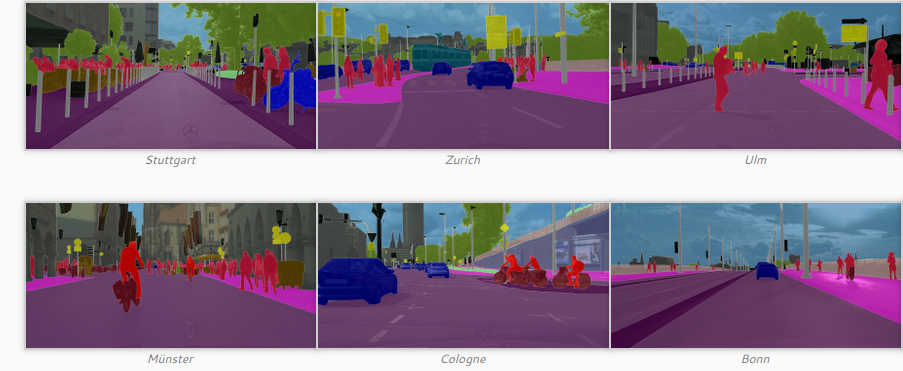

# Datasets

Datasets interesantes para usar en el taller

  
* ConferenceVideoSegmentationDataset: https://github.com/kuangzijian/Flow-Based-Video-Segmentation 
  * Data url: https://drive.google.com/file/d/13JKwoCaoSWQAjJ1YLVfV6AHvm8by09fP/view
  * Cuatro videos estilo conferencia con segmentaciones de las personas. 
  * Dataset creado semi artificialmente utilizando una pantalla verde de fondo

* The Oxford-IIIT Pet Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/
  * 36 tipos de máscotas segmentadas con 200 imágenes por tipo
  * Anotaciones de backgroud, edges y foreground.

* Colecciones de datasets: 
  * Papers with Code: https://paperswithcode.com/datasets?q=segmentation&v=lst&o=match&page=1
  * Kaggle: https://www.kaggle.com/datasets
  * UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/index.php
  * Google Dataset Search: https://datasetsearch.research.google.com/
  * Visual Data: https://visualdata.io/discovery

# Recursos

TensorFlow (TF2): https://www.tensorflow.org/
Keras: https://keras.io/

*   Tutoriales TF2: https://www.tensorflow.org/tutorials
  *   Ssegmentación: https://www.tensorflow.org/tutorials/images/segmentation
  *   Autoencoder variacional: https://www.tensorflow.org/tutorials/generative/cvae
*   Tutoriales keras: https://keras.io/examples/
  *   Segmentación con U-Net: https://keras.io/examples/vision/oxford_pets_image_segmentation/
  *   Autoencoder para denoising: https://keras.io/examples/vision/autoencoder/
  *   Segementación con DeepLabV3+: https://keras.io/examples/vision/deeplabv3_plus/


# Arquitecturas de red para segmentación


## Autoencoder

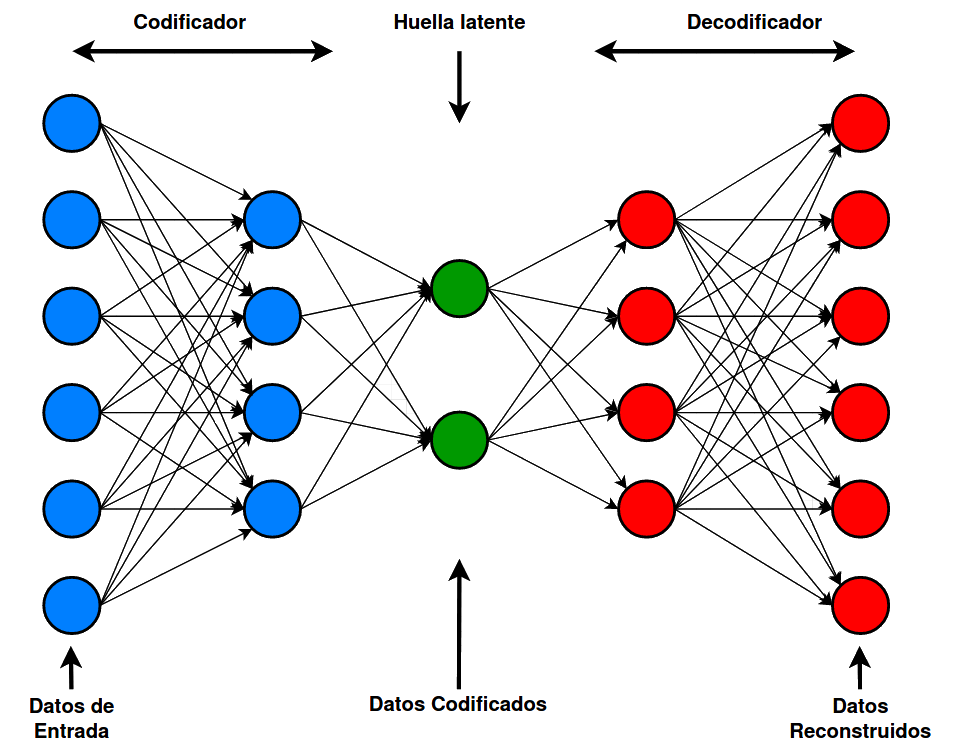


KRAMER, Mark A. Nonlinear principal component analysis using autoassociative neural networks. AIChE journal, 1991, vol. 37, no 2, p. 233-243.  https://doi.org/10.1002/aic.690370209

## U-Net


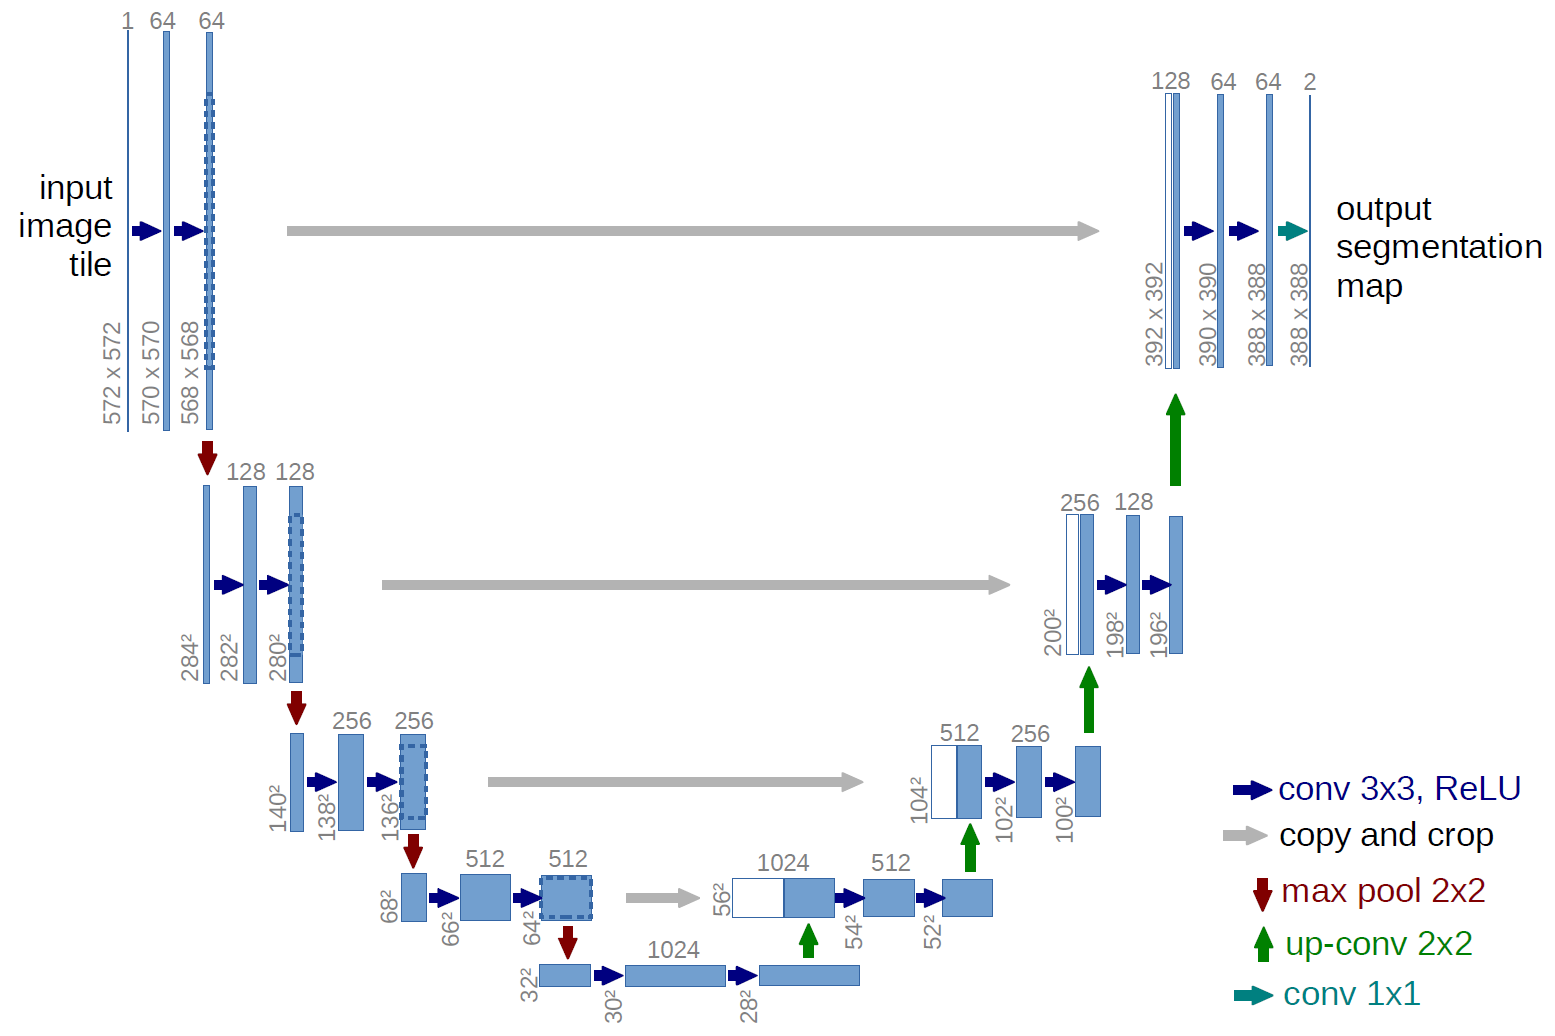


Ronneberger O., Fischer P., Brox T. (2015) U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab N., Hornegger J., Wells W., Frangi A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science, vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

## Autoencoder Variacional

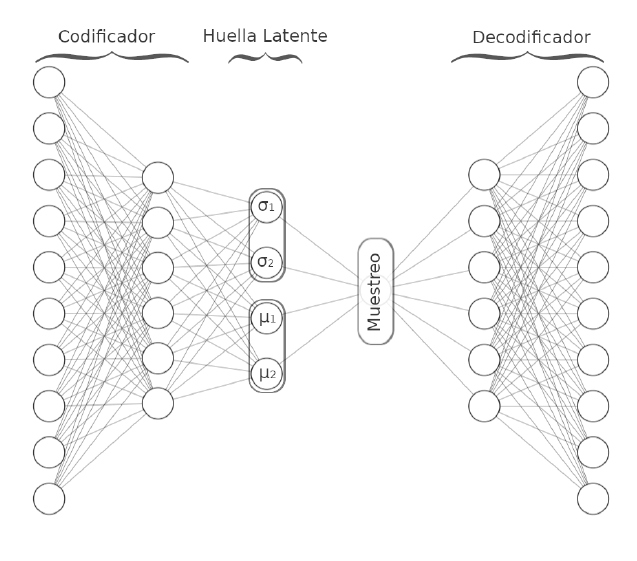




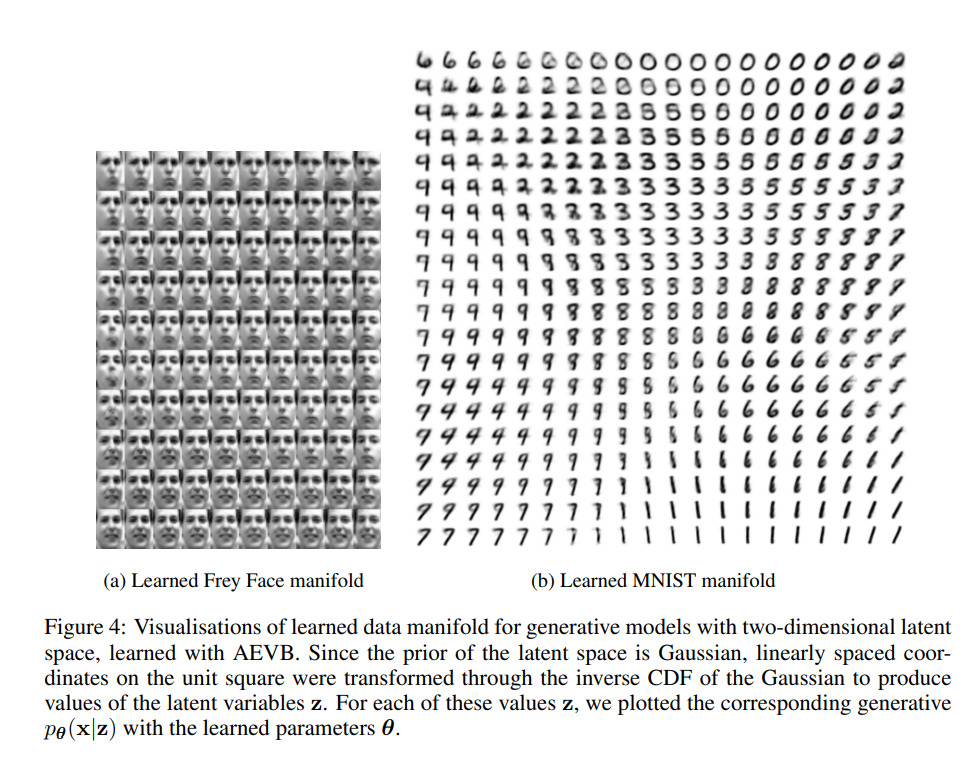



Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. 

Finalmente podemos crear diferentes arquitecturas de red para solucionar problemas específicos. En este caso de autoencoder variacional no solo se realiza una segmentación semántica, si no que además se extrae una imagen de profundidad y se reconstruye la imagen real.

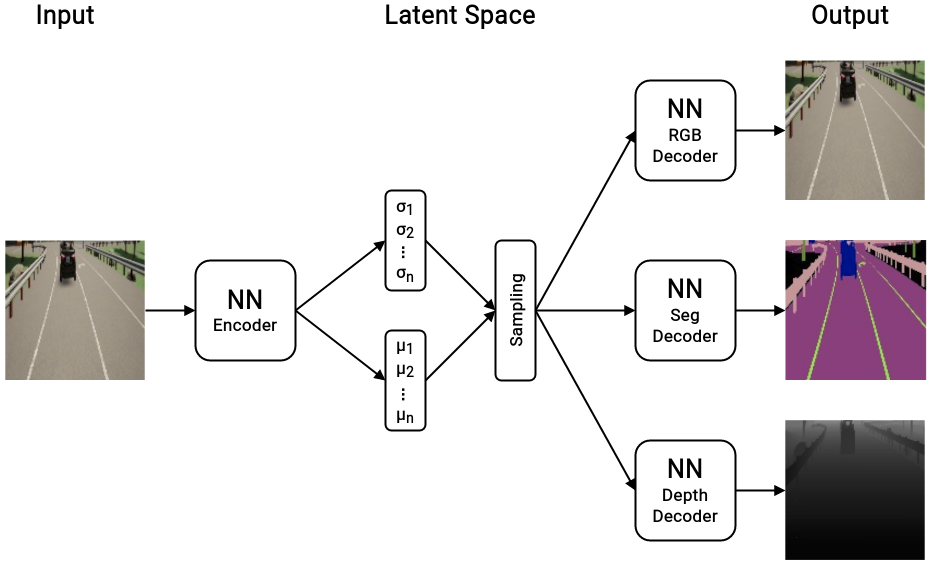

Hernández-García S., Cuesta-Infante A. (2021) Deep Reinforcement and Imitation Learning for Self-driving Tasks. In: Alba E. et al. (eds) Advances in Artificial Intelligence. CAEPIA 2021. Lecture Notes in Computer Science, vol 12882. Springer, Cham. https://doi.org/10.1007/978-3-030-85713-4_7

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
import cv2

import numpy as np
from matplotlib import image as plt_image
import matplotlib.pyplot as plt
import argparse
import os

from tensorflow.python.keras.models import model_from_json

# Preprocesado de datos

En primer lugar tenemos que obtener acceso a nuestro google drive


El dataset se encuentra en: https://drive.google.com/file/d/1ChXfmym3HinaQ_3Bg37xQdUleaFb5F70/view?usp=sharing

Añadelo a tu google drive, no es necesario que lo descargues

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


Buscamos la url del datset dentro de nuestro drive y lo descomprimimos el dataset en la url indicadas

In [3]:
!unzip -u "/content/drive/MyDrive/Colab Notebooks/teller segmentacion/ConferenceVideoSegmentationDataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/teller segmentacion/tmp"

Archive:  /content/drive/MyDrive/Colab Notebooks/teller segmentacion/ConferenceVideoSegmentationDataset.zip


In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/teller segmentacion/tmp/"

training_in = os.listdir(os.path.join(data_path, "original_training"))
training_label = os.listdir(os.path.join(data_path, "ground_truth_training"))

# Ordenamos las imágenes por sequencia
training_in.sort(key= lambda x : (int(x.split("_")[0].split("l")[1]), int(x.split(".")[0].split("_")[1])))
training_label.sort(key= lambda x : (int(x.split("_")[0].split("t")[1]), int(x.split(".")[0].split("_")[1])))

print('Training size: ', len(training_in))
print(training_in[:10])
print(training_label[:10])

Training size:  1326
['original1_1.jpg', 'original1_2.jpg', 'original1_3.jpg', 'original1_4.jpg', 'original1_5.jpg', 'original1_6.jpg', 'original1_7.jpg', 'original1_8.jpg', 'original1_9.jpg', 'original1_10.jpg']
['gt1_1.jpg', 'gt1_2.jpg', 'gt1_3.jpg', 'gt1_4.jpg', 'gt1_5.jpg', 'gt1_6.jpg', 'gt1_7.jpg', 'gt1_8.jpg', 'gt1_9.jpg', 'gt1_10.jpg']


Cargamos los datos de entrenamiento en un numpy array.

En este ejemplo ce cargan solo las 100 primeras imágenes.

In [5]:
x_train = [plt_image.imread(os.path.join(data_path, "original_training", name)) for name in training_in[:1000]]
y_train = [plt_image.imread(os.path.join(data_path, "ground_truth_training", name)) for name in training_label[:1000]]
print('Training size: ', len(x_train))


Training size:  1000


Para este caso de ejemplo vamos a ajustar el tamaño de los datos. Lo vamos a reducir desde su tamaño inicial (360, 640) a (128, 128) por tres motivos:


1.   Para ajustarlos al tamaño de entrada que nos interesa en la red neuronal
2.   Para que al realizar convoluciones con stride=2 no quede ninguna dimensión imapar. Si se diese ese caso luego tendríamos problemas para recuperar el tamaño original a la salida del autoencoder.
3.   Para simplificar y acelerar el procesamiento a efectos prácticos de este taller.




In [6]:
for i in range(len(x_train)):
    x_train[i] = cv2.resize(x_train[i], (128, 128))
    y_train[i] = cv2.resize(y_train[i], (128, 128))

Realizamos una visualización de los datos para ver que tras la transformación anterior siguen siendo correctos.

Input image shape:  (128, 128, 3)
Label image shape:  (128, 128, 3)


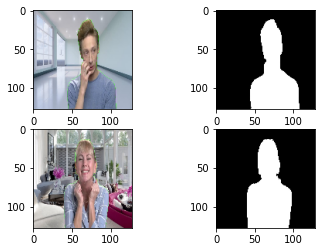

Train images range: : [ 0 ,  255 ]
Test images range: : [ 0 , 255 ]


In [7]:

n_img = np.random.randint(0, len(x_train))
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

plt.subplot(2, 2, 1)
plt.imshow(img_in)

plt.subplot(2, 2, 2)
plt.imshow(img_label)

n_img = np.random.randint(0, len(x_train))
img_in = x_train[n_img]
img_label = y_train[n_img]

plt.subplot(2, 2, 3)
plt.imshow(img_in)

plt.subplot(2, 2, 4)
plt.imshow(img_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Test images range: : [", np.amin(img_label), ",", np.amax(img_label), "]")

Como se puede observar en la celda anterior, los datos se encuentran en el rango de valores [0, 255]. Nos interesa normalizarlos al rango [0, 1] y convertirlos a tipo float32.

Posteriormente nos quedamos solo con uno de los tres canales de las imágenes segmentadas ya que se encuentran triplicados.

In [8]:
# Normalizamos los datos de entrada en rango [0, 1]
x_train = np.array(x_train, dtype=np.float32) / 255.
y_train = np.array(y_train, dtype=np.float32) / 255.

# Nos quedamos solo con el primer canal de las etiquetas
y_train = np.expand_dims(y_train[:, :, :, 0], axis=-1)

print('Input image shape: ', x_train[0].shape)
print('Label image shape: ', y_train[0].shape)

print("Train images range: : [", np.amin([x_train[0]]), ", ", np.amax(x_train[0]), "]")
print("Test images range: : [", np.amin(y_train[0]), ",", np.amax(y_train[0]), "]")

Input image shape:  (128, 128, 3)
Label image shape:  (128, 128, 1)
Train images range: : [ 0.0 ,  1.0 ]
Test images range: : [ 0.0 , 1.0 ]


Separamos un subconjunto de los datos para hacer validación.

In [9]:
# saparamos un subconjunto de validación

val_split = 0.15
val_split = int(x_train.shape[0] * val_split)
val_idx = np.random.choice(x_train.shape[0], val_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in val_idx else True for i in range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_val = x_train[val_idx]  # Seleccionamos datos de validacón
y_val = y_train[val_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Train samples:  850
Validation samples:  150


# Autoencoder

Se puede dividir en dos componentes principales: el codificador y el decodificador.



1.   Codificador: Red neuronal que transforma la entrada y la comprime en un vector o huella latente de dimensiones reducidad.
2.   Decodificador: Red neuronal que transforma la huella latente en un vector de características de interes (reconstrucción/descompresión de datos, segmentación, imagen de profundidad)


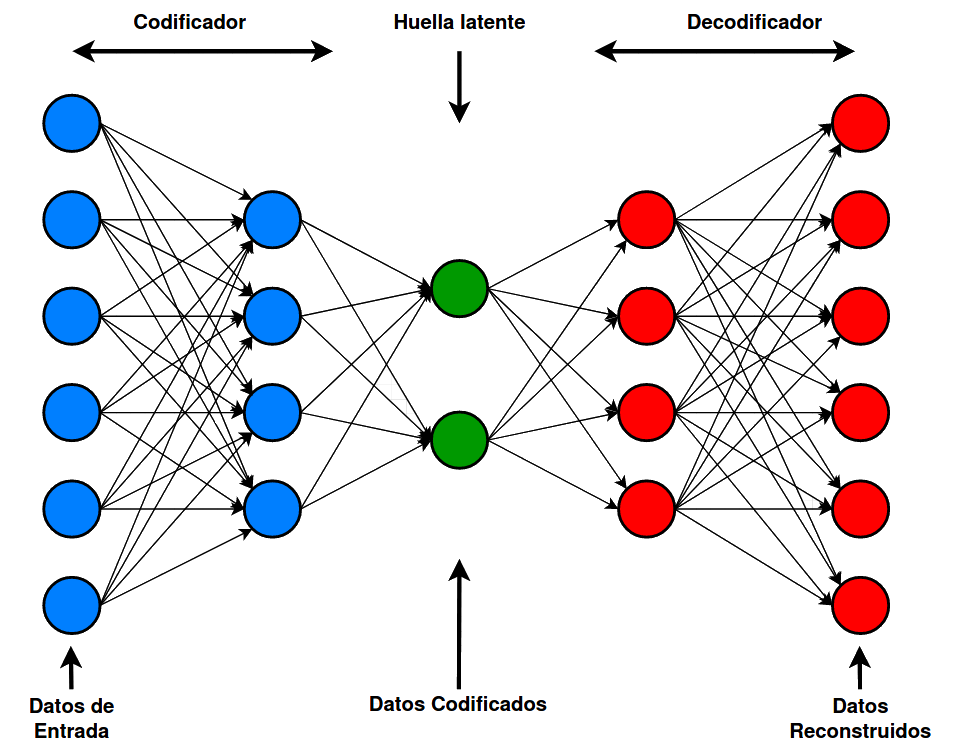



In [10]:
 def build_encoder(inputs, input_shape, kernel_size):
    # build encoder model
    x = inputs

    x = Conv2D(filters=64,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=64,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=128,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = Conv2D(filters=256,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

    # shape info needed to build decoder model
    last_conv_shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(last_conv_shape[1] * last_conv_shape[2] * last_conv_shape[3], activation='relu')(x)
    latent = Dense(latent_dim, activation="tanh", name='latent')(x)  # activación tanh para mantener valores en [-1, 1]

    # instantiate encoder model
    encoder = tf.keras.models.Model(inputs, latent, name='encoder')
    encoder.summary()
    return encoder, last_conv_shape

In [11]:
def build_decoder(latent_dim, shape): 
    # build decoder model
    latent_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)


    x = Conv2DTranspose(filters=256,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=128,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=64,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = Conv2DTranspose(filters=64,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    output = Conv2DTranspose(filters=out_channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)  # Activación sigmoide para que las salidas estén en rango [0, 1]
                          
    # instantiate decoder model
    decoder = tf.keras.models.Model(latent_input, output, name='decoder')
    decoder.summary()
    
    return decoder

In [12]:
def build_model(input_shape=(128, 128, 3), out_channels=1, latent_dim=128, kernel_size=3):
    # AE model = encoder + decoder
    inputs = Input(shape=input_shape, name='encoder_input')

    encoder, last_conv_shape = build_encoder(inputs, input_shape, kernel_size)
    decoder = build_decoder(latent_dim, last_conv_shape) 

    # instantiate VAE model
    output = decoder(encoder(inputs))

    labels = Input(shape=(*input_shape[:-1], out_channels), name='lables')

    autoencoder =  tf.keras.models.Model(inputs, output, name='AE')

    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.5))

    return encoder, decoder, autoencoder


Construimos el modelo de AE.
Seleccionamos el número de canales en función del número de etiquetas.

In [13]:
input_shape=(128, 128, 3)
out_channels=1
latent_dim=128
kernel_size=3

encoder, decoder, vae = build_model(input_shape, out_channels, latent_dim, kernel_size)


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 16384)             2684

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Entrenamos el Auto Encoder


In [ ]:
batch_size = 128
epochs = 50

vae.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_val, y_val))

Epoch 1/50
7/7 [==============================] - 126s 17s/step - loss: 0.6882 - binary_accuracy: 0.6819 - val_loss: 0.6762 - val_binary_accuracy: 0.7206
Epoch 2/50
7/7 [==============================] - 122s 17s/step - loss: 0.5685 - binary_accuracy: 0.7180 - val_loss: 0.4253 - val_binary_accuracy: 0.7206
Epoch 3/50


# Testing
En primer lugar vamos a pasar la red sobre el conjunto de test para ver si ha 
generalizado.

Para esto tenemos que cargar en primer lugar el conjunto de test.

In [ ]:
testing_in = os.listdir(os.path.join(data_path, "original_testing"))
testing_label = os.listdir(os.path.join(data_path, "ground_truth_testing"))

# Ordenamos las imágenes por sequencia
testing_in.sort(key=lambda x: (int(x.split("_")[0].split("l")[1]), int(x.split(".")[0].split("_")[1])))
testing_label.sort(key=lambda x: (int(x.split("_")[0].split("t")[1]), int(x.split(".")[0].split("_")[1])))
x_test = [plt_image.imread(os.path.join(data_path, "original_testing", name)) for name in testing_in[:100]]
y_test = [plt_image.imread(os.path.join(data_path, "ground_truth_testing", name)) for name in testing_label[:100]]

Aplicaremos las mismas transformaciones que en el conjunto de entrenamiento, es decir, redimensionaremos laas imágenes hasta el tamaño de entrada de la red y normalizaremos los datos. 

In [ ]:
for i in range(len(x_test)):
    x_test[i] = cv2.resize(x_test[i], (128, 128))
    y_test[i] = cv2.resize(y_test[i], (128, 128))

# Normalizamos los datos de entrada en rango [0, 1]
x_test = np.array(x_test) / 255.
y_test = np.array(y_test) / 255.
y_test = np.expand_dims(y_test[:, :, :, 1], axis=-1)

la función evaluate realiza un predict sobre cada entrada del conjunto de test y extrae las métricas que hayamos indicado al compilar el modelo.

In [ ]:
vae.evaluate(x_test, y_test, batch_size=batch_size)

Por último, vamos a visualizar algunos de los resultados. 

La siguiente celda selecciona varias imágenes aleatorias y muestra su salida.

In [ ]:
figsize = 5
num_examples_to_generate = figsize*figsize
fig = plt.figure()
fig.suptitle('Resultados segmentación')
examples_index = np.random.choice(x_test.shape[0], figsize*2)
examples = x_test[examples_index]
lattent = encoder.predict(examples)
predictions = decoder.predict(lattent)

predictions[predictions > 0.5] = 1.0
predictions[predictions <= 0.5] = 0.0

predictions = np.squeeze(predictions, axis=-1)  # (w, h, 1) -> (w, h)

for i in range(figsize*2):

    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(predictions[i], cmap='gray')

plt.axis('off')
plt.show()